In [3]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
import numba
from numba import cuda
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
from sklearn import svm
from scipy.linalg import norm

np.set_printoptions(threshold=50)

In [4]:
# import numpy as np 
# X, y = make_classification(n_samples=1000, n_features=4, n_informative=4, n_redundant=0, random_state=42)
 
# # Train a Logistic Regression model (or any other classifier)
# model = LogisticRegression()
# model.fit(X, y)

In [5]:
# Reading in the dataset
df=pd.read_csv('SVM_Dataset2.csv')

# svm_classifier.fit(df[['x1', 'x2']], df[['y']])

In [6]:
def broadcast_compute(Z, grid, epsilon): 
    for i in range(len(grid) - 1):
        # Compute broadcasted points (difference between grid[i,:] and all other points)
        broadcasted_pts = grid[i, :] - grid  # This creates a matrix of differences

        # Compute the row-wise norm of broadcasted points
        norm_broadcasted_pts = np.linalg.norm(broadcasted_pts, axis=1)

        # Compute the difference in predictions
        Z_vec = Z[i] - Z

        # Create a mask where the norm is less than epsilon and Z_vec equals -1
        mask = (norm_broadcasted_pts < epsilon) & Z_vec != 0

        # Find the indices where the mask is true
        masked_indices = np.where(mask)[0]  # Use [0] to extract the array of indices from the tuple

        # Compute new points as the midpoint between grid[i,:] and the masked points
        new_pts = (grid[i, :] + grid[masked_indices]) / 2

        # Append new points to the boundary_points array
        boundary_points = np.append(boundary_points, new_pts, axis=0)
    
    boundary_points = boundary_points[1:,:]
    return boundary_points

def compute_decision_boundary_points_gpu(model, X, resolution=100, epsilon=0.01):
    n_features = X.shape[1]    
    grid = np.zeros((resolution ** n_features, n_features))
    for i, feature in enumerate(range(n_features)):
        cp_array = np.linspace(X[:, feature].min() - 1, X[:, feature].max() + 1, resolution ** (n_features)).reshape(-1)
        grid[:, i] = cp_array
    Z = np.asarray(model.predict(grid))
    return broadcast_compute(Z, grid, epsilon)

In [26]:
import cupy as cp

@numba.njit
def find_boundary_cpu(grid, Z, epsilon):
    boundary_points = []
    
    for i in range(len(grid) - 1):
        for j in range(i + 1, len(grid)):
            if np.linalg.norm(grid[i] - grid[j]) < epsilon and Z[i] != Z[j]:
                midpoint = (grid[i] + grid[j]) / 2
                boundary_points.append(midpoint)
    return boundary_points

@numba.njit
def cartesian_product_numba(arrays, out):
    n_arrays = len(arrays)
    shape = [len(a) for a in arrays]
    for idx in range(out.shape[0]):
        remainder = idx
        for dim in range(n_arrays - 1, -1, -1):
            size = shape[dim]
            out[idx, dim] = arrays[dim][remainder % size]
            remainder = remainder // size

@cuda.jit
def cartesian_product_cuda(arrays, n_arrays, out):
    idx = cuda.grid(1)  # Global thread index
    if idx < out.shape[0]:
        stride = 1
        for i in range(n_arrays - 1, -1, -1):
            arr_len = arrays[i].shape[0]
            out[idx, i] = arrays[i][(idx // stride) % arr_len]
            stride *= arr_len

def compute_cartesian_product_cuda(arrays):
    # Calculate output shape
    shape = [len(a) for a in arrays]
    out_size = np.prod(shape)
    n_arrays = len(arrays)
    
    # Check for memory feasibility
    if out_size > 10**9:  # Arbitrary limit to avoid memory issues
        raise ValueError(f"Output size {out_size} is too large for GPU memory")
    
    # Allocate output array
    out = cp.zeros((out_size, n_arrays), dtype=np.float32)
    
    # Transfer arrays to device
    d_arrays = cp.asarray([cuda.to_device(np.array(arr, dtype=np.float32)) for arr in arrays])
    d_out = cuda.to_device(out)
    
    # Configure CUDA grid and block sizes
    threads_per_block = 128
    blocks_per_grid = (out_size + threads_per_block - 1) // threads_per_block
    
    # Launch kernel
    cartesian_product_cuda[blocks_per_grid, threads_per_block](d_arrays, n_arrays, d_out)
    
    # Copy result back to host
    result = d_out.copy_to_host()
    return result


@cuda.jit 
def find_boundary_gpu(grid, Z, epsilon, boundary_points, count):
    i = cuda.grid(1)
    n = grid.shape[0]

    if i < n:
        for j in range(i + 1, n):
            dist = 0.0
            for k in range(grid.shape[1]):
                diff = grid[i, k] - grid[j, k]
                dist += diff * diff
            dist = dist ** 0.5

            if dist < epsilon and Z[i] != Z[j]:
                idx = cuda.atomic.add(count, 0, 1)
                for d in range(grid.shape[1]):
                    boundary_points[idx, d] = (grid[i, d] + grid[j, d]) / 2

def compute_decision_boundary_points_cpu(model, X, resolution=100, epsilon=0.01):
    """
    Compute decision boundary points in the high-dimensional feature space.
    Args:
        model: Trained classifier.
        X: Input data (n_samples, n_features).
        resolution: Number of points to sample along each feature axis.
        epsilon: Small step size to detect class changes.
    Returns:
        boundary_points: Array of points near the decision boundary.
    """
    n_features = X.shape[1]
    linspaces = [] 
    
    for i in range(n_features):
        dim =  np.linspace(X.iloc[:, i].min() - 1, X.iloc[:, i].max() + 1, resolution)
        linspaces.append(dim) 

    total_size = np.prod([len(arr) for arr in linspaces])
    out = np.empty((total_size, len(linspaces)), dtype=np.float64)
    arrays = tuple(np.asarray(arr) for arr in linspaces)
    cartesian_product_numba(arrays, out)
    Z = model.predict(out)
    boundary_points = find_boundary_cpu(out, Z, epsilon)
    boundary_df = pd.DataFrame(boundary_points, columns=X.columns)
    return boundary_df

def compute_decision_boundary_points_gpu(model, X, resolution=100, epsilon=0.01):
    """
    Compute decision boundary points in the high-dimensional feature space.
    Args:
        model: Trained classifier.
        X: Input data (n_samples, n_features).
        resolution: Number of points to sample along each feature axis.
        epsilon: Small step size to detect class changes.
    Returns:
        boundary_points: Array of points near the decision boundary.
    """
    n_features = X.shape[1]
    linspaces = [] 
    
    for i in range(n_features):
        dim =  np.linspace(X.iloc[:, i].min() - 1, X.iloc[:, i].max() + 1, resolution)
        linspaces.append(dim) 

    
    grid = compute_cartesian_product_cuda(linspaces)
    Z = model.predict(grid)

    d_grid = cuda.to_device(grid)
    d_Z = cuda.to_device(Z)
    grid_size = resolution ** n_features
    max_boundary_points = grid_size  # worst case
    d_boundary_points = cuda.device_array((max_boundary_points, n_features), dtype=np.float32)
    d_count = cuda.to_device(np.array([0], dtype=np.int32))

    threads_per_block = 128
    blocks_per_grid = (grid_size + threads_per_block - 1) // threads_per_block

    find_boundary_gpu[blocks_per_grid, threads_per_block](d_grid, d_Z, epsilon, d_boundary_points, d_count)

    count = d_count.copy_to_host()[0]
    boundary_points = d_boundary_points.copy_to_host()[:count]

    return boundary_points

# Experiments of the Computation Costs for CPU only 

$\textbf{ CPU used: AMD Ryzen 9 7950X 16-Core processor}$

- 50 Resolution (R = 50) with CPU only 
- 47 minutes - Does not finish 

- 25 Resolution (R = 25) with CPU only 
- 23 minutes - Does not finish 

- 20 Resolution (R = 20) with CPU only 
- 20 minutes - Does not finish

- 15 Resolution (R = 15) with CPU only 
- 26 minutes - Does not finish 

- 12 Resolution (R = 12) with CPU only 
- 6 minute runtime Done

- 10 Resolution (R = 10) with CPU only 
- 85 seconds Done

- 7 Resolution (R = 7) with CPU only
- 5 seconds Done

- 5 Resolution (R = 5) with CPU only 
- 0.3 second runtime

# Experiments with CPU only (with Numba) 

- 20 Resolution (R = 20) with CPU 
- Over 10 minutes - NOT DONE

- 17 Resolution (R = 17) with CPU 
- 6 minute runtime

- 15 Resolution (R = 15) with CPU 
- 2 minute runtime

- 10 Resolution (R = 10) with CPU 
- 6 second runtime

c:\Users\Compuworld\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Decision Boundary Points (All Features):
             x1         x2
0      3.140562  20.829317
1      3.140562  20.863454
2      3.140562  20.897590
3      3.140562  20.897590
4      3.140562  20.931727
...         ...        ...
1045  16.915663  11.339357
1046  16.943775  11.339357
1047  16.971888  11.339357
1048  16.971888  11.339357
1049  17.000000  11.339357

[1050 rows x 2 columns]
(1050, 2)


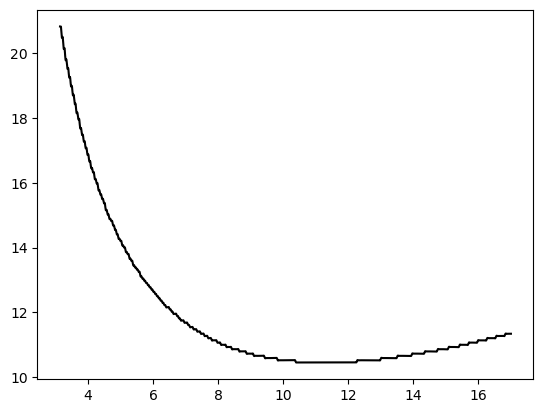

In [13]:
svm_classifier = svm.SVC(kernel='poly',C=10, degree=2, probability=True)
svm_classifier.fit(df[['x1', 'x2']], df['y'].values)
# Compute decision boundary points considering all features
boundary_points = compute_decision_boundary_points_cpu(svm_classifier, df[['x1','x2']], resolution=250, epsilon=0.1)
 
# Print the decision boundary points
print("Decision Boundary Points (All Features):")
print(boundary_points)
print(boundary_points.shape)

boundary_points = boundary_points.drop_duplicates(subset='x1')
bound_x, bound_y = boundary_points.iloc[:,0], boundary_points.iloc[:, 1]

N = 1000000
lower_boundx, upper_boundx = np.min(bound_x), np.max(bound_x)
f = interp1d(bound_x, bound_y, kind='cubic')
X_pred = np.linspace(lower_boundx, upper_boundx, N)[:, np.newaxis]
Y_pred = f(X_pred)
lower_boundy, upper_boundy = np.min(bound_y), np.max(bound_y)
x_min, x_max = bound_x.min(), bound_x.max()
y_min, y_max = bound_y.min(), bound_y.max()

X_pred = np.clip(X_pred, x_min, x_max)
Y_pred = np.clip(Y_pred, y_min, y_max)
plt.plot(X_pred, Y_pred, color='black')

# undesired_datapt = np.array([undesired_coords[0], undesired_coords[1]])
# optimal_datapt = closest_point(undesired_datapt, contour=contours)

In [16]:
print("Decision Boundary Points (Probability Across Both classes):")
boundary_points.predict_proba(boundary_points) 

Decision Boundary Points (Probability Across Both classes):


AttributeError: 'DataFrame' object has no attribute 'predict_proba'

# Experiments with GPU (with Numba) 

- 20 Resolution (R = 20) with GPU 
- 5.9 second runtime

- 15 Resolution (R = 15) with GPU 
- 1.0 second runtime

c:\Users\Compuworld\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Decision Boundary Points (All Features):
[[ 3.6452906 18.325651 ]
 [ 3.5611222 18.700401 ]
 [ 3.8416834 17.508015 ]
 ...
 [16.901804  11.307615 ]
 [16.901804  11.341682 ]
 [16.901804  11.324649 ]]
(13624, 2)


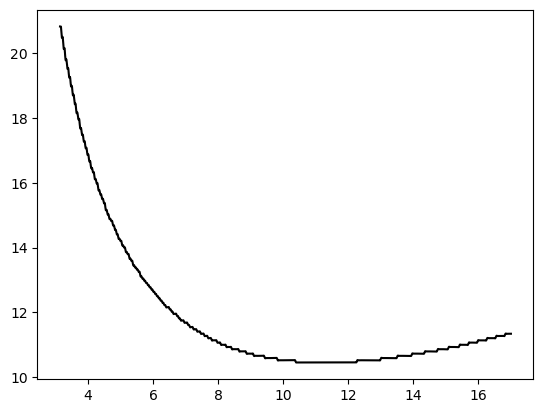

In [30]:
# Compute decision boundary points considering all features
boundary_points = compute_decision_boundary_points_gpu(svm_classifier, df[['x1','x2']], resolution=500, epsilon=0.1)
 
# Print the decision boundary points
print("Decision Boundary Points (All Features):")
print(boundary_points)
print(boundary_points.shape)

N = 1000000
lower_boundx, upper_boundx = np.min(bound_x), np.max(bound_x)
f = interp1d(bound_x, bound_y, kind='cubic')
X_pred = np.linspace(lower_boundx, upper_boundx, N)[:, np.newaxis]
Y_pred = f(X_pred)
lower_boundy, upper_boundy = np.min(bound_y), np.max(bound_y)
x_min, x_max = bound_x.min(), bound_x.max()
y_min, y_max = bound_y.min(), bound_y.max()

X_pred = np.clip(X_pred, x_min, x_max)
Y_pred = np.clip(Y_pred, y_min, y_max)
plt.plot(X_pred, Y_pred, color='black')

In [7]:
print("Decision Boundary Points (Probability Across Both classes):")
model.predict_proba(boundary_points) 

Decision Boundary Points (Probability Across Both classes):


array([[0.49999349, 0.50000651],
       [0.50000254, 0.49999746],
       [0.49998445, 0.50001555],
       ...,
       [0.50135906, 0.49864094],
       [0.50134097, 0.49865903],
       [0.50132289, 0.49867711]])

In [8]:
from scipy.interpolate import griddata

n_features = X.shape[1]
print(n_features)
ranges = [np.linspace(X[:, j].min() - 1, X[:, j].max() + 1, 100) for j in range(n_features)]
grids = np.meshgrid(*ranges)
new_points = np.random.rand(1000, n_features-1)
X_vals, y_vals = boundary_points[:,0:n_features-1], boundary_points[:,-1] 

interpolated_values = griddata(X_vals, y_vals, new_points, method='cubic')

4


ValueError: Unknown interpolation method 'cubic' for 3 dimensional data

In [9]:
from scipy.interpolate import RBFInterpolator 
print(boundary_points.shape)
n_features = X.shape[1]
X_vals, y_vals = boundary_points[:,0:n_features-1], np.reshape(boundary_points[:,-1], (-1,1)) 
print(y_vals.shape)
interpolator = RBFInterpolator(X_vals, y_vals, kernel='cubic', smoothing=1e-12)

(160000, 4)
(160000, 1)


MemoryError: (unable to allocate 18446744073541027856 bytes)

In [17]:
n_features = X.shape[1]
ranges = [np.linspace(boundary_points[:, j].min(), boundary_points[:, j].max(), 25) for j in range(n_features)]
grids = np.meshgrid(*ranges) 

grid_points = np.vstack([g.ravel() for g in grids]).T
print(grid_points.shape)

(390625, 4)


In [18]:
print(grid_points.shape)

(390625, 4)


In [19]:
eval_coords = grid_points[:,0:n_features-1]
print(eval_coords.shape)
eval_values = interpolator(eval_coords)
add_boundary_pts = np.hstack((eval_coords, eval_values))
print(eval_coords.shape)
print(eval_values.shape)
print(add_boundary_pts.shape)

(390625, 3)
(390625, 3)
(390625, 1)
(390625, 4)


# Interpolating Additional Boundary points Using N-1 data point coordinates 

In [20]:
arr = model.predict_proba(add_boundary_pts)

In [21]:
average_diff = np.mean(arr[:, 0] - arr[:, 1])
print("Average difference:", average_diff)

Average difference: -3.008925147444152e-06
